## DBSCAN 

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
import seaborn as sns

KeyboardInterrupt: 

In [ ]:
# Load the dataset
data = pd.read_excel("./data/horn_bill_telemetry.xlsx")

# Preprocessing (if not already done)
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['month'] = data['timestamp'].dt.month
data['year'] = data['timestamp'].dt.year

# Combine month and year into a single column for better x-axis labeling
data['month_year'] = data['timestamp'].dt.strftime('%B %Y')

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Sample DataFrame 'data' with columns as in the example
# Assume `data` is already loaded and contains columns: 'location-long', 'location-lat', 'month', 'year', 'event-id', etc.

# Select features for clustering
features = ['location-long', 'location-lat', 'month', 'year']
X = data[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN
dbscan = DBSCAN(eps=1, min_samples=200)  # Adjust eps and min_samples as needed
data['cluster'] = dbscan.fit_predict(X_scaled)

# Extract Behavioral Insights: Analyze common locations and times
# Group by cluster, month, and year to understand patterns
# Create a combined 'month_year' column for grouping
data['month_year'] = data['month'].astype(str) + '-' + data['year'].astype(str)
behavioral_insights = data.groupby(['cluster', 'month_year']).agg({
    'location-long': 'mean',
    'location-lat': 'mean',
    'timestamp': 'count'
}).reset_index()

# Rename timestamp count for clarity
behavioral_insights.rename(columns={'timestamp': 'visit_count'}, inplace=True)

# Convert month_year to datetime for sorting
behavioral_insights['month_year'] = pd.to_datetime(behavioral_insights['month_year'], format='%m-%Y')
behavioral_insights.sort_values('month_year', inplace=True)

# Save the behavioral insights DataFrame to an Excel file
output_file_path = './insights/behavioral_insights_dbscan.xlsx'
behavioral_insights.to_excel(output_file_path, index=False)

# Add the cluster assignments to the original DataFrame for record-keeping
data_with_clusters = data[['event-id', 'individual-local-identifier', 'individual-taxon-canonical-name', 
                           'location-long', 'location-lat', 'timestamp', 'cluster']]

# Save the DataFrame with clusters to an Excel file
output_file_with_clusters = './insights/data_with_clusters_dbscan.xlsx'
data_with_clusters.to_excel(output_file_with_clusters, index=False)

# Print each cluster's centroid (mean of 'location-long' and 'location-lat')
print("Centroids of each cluster:")
centroids = data.groupby('cluster')[['location-long', 'location-lat']].mean()
print(centroids)

print("DBSCAN clustering and behavioral insights saved successfully.")


Centroids of each cluster:
         location-long  location-lat
cluster                             
-1           93.023786     26.948648
 0           92.964022     26.934626
 1           92.941587     26.950045
 2           92.993482     27.080669
 3           92.927397     26.945450
DBSCAN clustering and behavioral insights saved successfully.


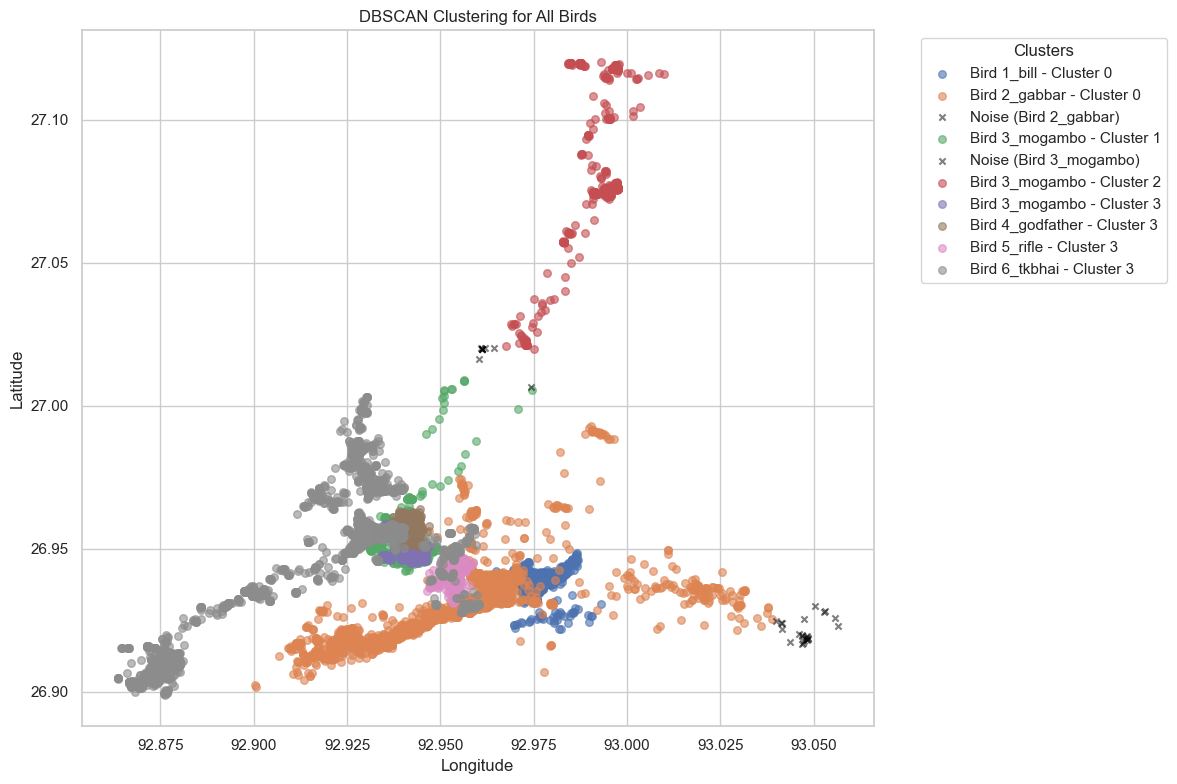

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data with DBSCAN cluster labels
data_with_clusters = pd.read_excel('./insights/data_with_clusters_dbscan.xlsx')

# Set up the plot style
sns.set(style="whitegrid")

# Set up the figure for all birds' clustering results
plt.figure(figsize=(12, 8))

# Loop through each bird to plot on the same map
for bird_id in data_with_clusters['individual-local-identifier'].unique():
    # Filter data for the specific bird
    df_bird = data_with_clusters[data_with_clusters['individual-local-identifier'] == bird_id]

    # Loop through each DBSCAN cluster for this bird
    for cluster_label in df_bird['cluster'].unique():
        # Identify noise points (DBSCAN marks noise as -1)
        if cluster_label == -1:
            # Plot noise points in black
            noise_points = df_bird[df_bird['cluster'] == -1]
            plt.scatter(noise_points["location-long"], noise_points["location-lat"], 
                        c='black', label=f'Noise (Bird {bird_id})', s=20, marker='x', alpha=0.5)
        else:
            # Plot cluster points with a unique color
            cluster_points = df_bird[df_bird['cluster'] == cluster_label]
            plt.scatter(cluster_points["location-long"], cluster_points["location-lat"], 
                        label=f'Bird {bird_id} - Cluster {cluster_label}', s=30, alpha=0.6)

# Title and labels for the plot
plt.title("DBSCAN Clustering for All Birds")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the map
plt.tight_layout()
plt.show()


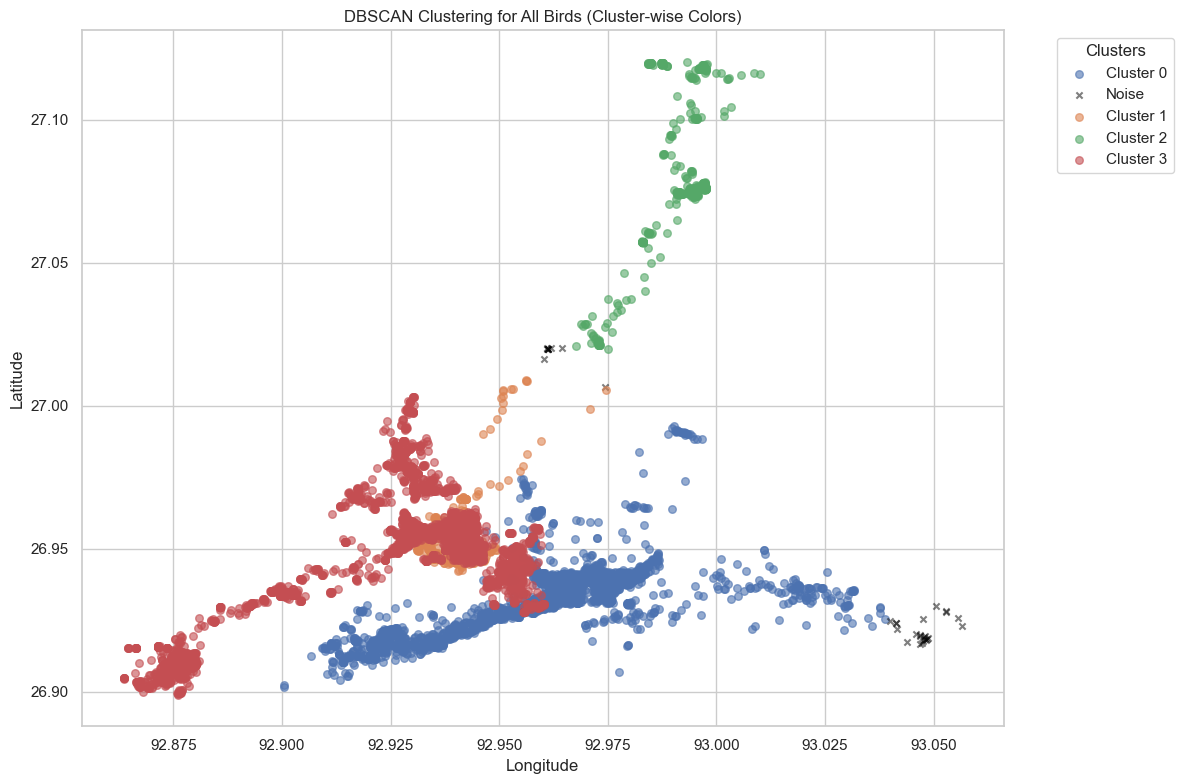

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data with DBSCAN cluster labels
data_with_clusters = pd.read_excel('./insights/data_with_clusters_dbscan.xlsx')

# Set up the plot style
sns.set(style="whitegrid")

# Set up the figure for all birds' clustering results
plt.figure(figsize=(12, 8))

# Loop through each DBSCAN cluster for all birds and plot them
unique_clusters = data_with_clusters['cluster'].unique()
for cluster_label in unique_clusters:
    # Identify noise points (DBSCAN marks noise as -1)
    if cluster_label == -1:
        # Plot noise points in black
        noise_points = data_with_clusters[data_with_clusters['cluster'] == -1]
        plt.scatter(noise_points["location-long"], noise_points["location-lat"], 
                    c='black', label='Noise', s=20, marker='x', alpha=0.5)
    else:
        # Plot cluster points with a unique color
        cluster_points = data_with_clusters[data_with_clusters['cluster'] == cluster_label]
        plt.scatter(cluster_points["location-long"], cluster_points["location-lat"], 
                    label=f'Cluster {cluster_label}', s=30, alpha=0.6)

# Title and labels for the plot
plt.title("DBSCAN Clustering for All Birds (Cluster-wise Colors)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the map
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import plotly.express as px

# Sample DataFrames (replace these with your actual data)
df1 = pd.DataFrame(pd.read_excel('models/similarity_category.xlsx'))

df2 = pd.DataFrame(pd.read_excel("data/train.xlsx"))

# Add 'Month' column to df2 for merging
df1['MO'] = df1['Month']

# Merge df1 and df2 on 'LAT', 'LON', and 'Month'
combined_df = pd.merge(df1, df2, on=['LAT', 'LON', 'MO'], how='inner')

print(combined_df.head())

# # List of relevant columns for plotting
# relevant_columns = [
#     'ALLSKY_SFC_SW_DWN', 'T2M', 'T2MDEW', 'T2M_RANGE',  
#     'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M', 'PRECTOTCORR', 
#     'PS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN',
#     'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'NDVI', 'CI', 'ELEVATION'
# ]

# # Generate box plots for each relevant column
# for column_name in relevant_columns:
#     fig = px.box(combined_df, 
#                  x='Similarity_Category', 
#                  y=column_name, 
#                  color='Similarity_Category', 
#                  title=f'Box Plot of {column_name} by Similarity Category', 
#                  labels={'Similarity_Category': 'Similarity Category', column_name: column_name})
    
#     # Show the plot for each attribute
#     fig.show()


Empty DataFrame
Columns: [LAT, LON, Month, Similarity_Category, MO, YEAR, DY, ALLSKY_SFC_SW_DWN, T2M, T2MDEW, T2M_RANGE, T2M_MAX, T2M_MIN, QV2M, RH2M, PRECTOTCORR, PS, WS10M, WS10M_MAX, WS10M_MIN, WS50M, WS50M_MAX, WS50M_MIN, ELEVATION, NDVI, CI]
Index: []

[0 rows x 26 columns]
